In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
from statsmodels.tsa.tsatools import detrend
from functools import partial 
import xarray as xr
from thesis_toolbox.plot.tools import add_letter
from thesis_toolbox.utils import get_locations_CLP
import matplotlib.cm as cm
import matplotlib
from itertools import product
# latex_plot()
%matplotlib inline

In [2]:
def plot_correlations(df, figsize=(27,23)):
    corrs = df.corr()
    p_values = df.corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(len(df.columns)) 
    mask = np.triu(np.ones_like(corrs.values, dtype=bool))
    corrs_triu = corrs.where((mask==False)) 
    significant_corrs = corrs_triu.round(2).where((p_values <=0.05), other='')

    fig = plt.figure(figsize=figsize)
    ax = plt.axes()
    ax.set_aspect('equal')


    sns.heatmap(corrs.values, mask=mask,
                xticklabels=corrs.columns.values,annot=significant_corrs,
                yticklabels=corrs.columns.values, ax=ax, cmap='coolwarm',fmt='',annot_kws={'fontsize':8, 'color':'black'}, vmin=-1,vmax=1)

In [3]:
if 'snakemake' in globals():
    to_file = True
    path='./'
else:
    path = '../../../'
    to_file= False

In [4]:
df = pd.read_csv(path+'results/timeseries_table.csv',index_col=0)
df = df.rename(columns={'Temp gradient anomalies MAM':'EATG MAM','Temp gradient anomalies_DJF':'EATG DJF', 
                        'Emissions taklamakan':'Emission Taklamakan', 'Emissions mongolia': 'Emission Mongolia', 'Emissions north_west':'Emission north west CLP'})
df = df.drop(['NAO station MAM', 'NAO station DJF', 'Emissions total'], axis=1)

detrend_func = partial(detrend, axis=1)
detrended=df.apply(detrend_func,raw=True)

locs = get_locations_CLP().index
detrended = detrended.drop(labels=[f'Precip {loc} MAM' for loc in locs],axis=1)
detrended = detrended.drop(labels=[f'Precip {loc} DJF' for loc in locs],axis=1)


Remove some cluter from the table

In [5]:
remove_indicies = ['NAO EOF MAM', 'NAO EOF DJF', 'APVI MAM', 'APVI DJF']
detrended=detrended.drop(remove_indicies,axis=1)

Rename 20micron to silt and 2micron to clay so that is consistent with terinology used in the paper

In [6]:
wetdep_keys = product(locs, ['wetdep 20micron', 'wetdep 2micron'])
drydep_keys = [f'{loc} {tag}' for loc, tag in product(locs, ['drydep 20micron', 'drydep 2micron'])]
new_column_names = [f'{loc} {tag}' for loc, tag in product(locs, ['silt', 'clay'])]
wetdep_keys = [f'{loc} {tag}' for loc, tag in wetdep_keys]
detrended_drydep = detrended.drop(wetdep_keys, axis=1)
detrended_drydep = detrended_drydep.rename(columns={old_col_name:new_col_name for old_col_name, new_col_name in zip(drydep_keys, new_column_names)})
detrended_drydep = detrended_drydep.drop(['YINCHUAN clay', 'YINCHUAN silt'], axis=1)

detrended_wetdep = detrended.drop(drydep_keys, axis=1)
detrended_wetdep = detrended_wetdep.rename(columns={old_col_name:new_col_name for old_col_name, new_col_name in zip(wetdep_keys, new_column_names)})
detrended_wetdep = detrended_wetdep.drop(['YINCHUAN clay', 'YINCHUAN silt'], axis=1)

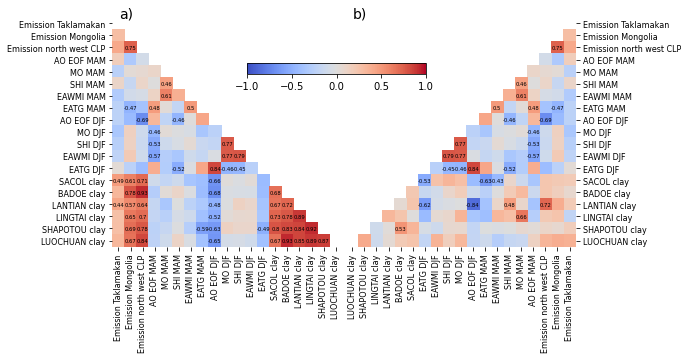

In [7]:
locs = locs.drop('YINCHUAN')
# remove the silt sizebin
detrended_drydep_clay = detrended_drydep.drop([loc + ' silt' for loc in locs], axis=1)
detrended_wetdep_clay = detrended_wetdep.drop([loc + ' silt' for loc in locs], axis=1)
corrs_drydep = detrended_drydep_clay.corr()
p_values_drydep = detrended_drydep_clay.corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(len(detrended_drydep_clay.columns)) 
mask_drydep = np.triu(np.ones_like(corrs_drydep.values, dtype=bool))
corrs_triu_drydep = corrs_drydep.where((mask_drydep==False)) 
significant_corrs_drydep = corrs_triu_drydep.round(2).where((p_values_drydep <=0.05), other='')

corrs_wetdep = detrended_wetdep_clay.corr()
p_values_wetdep = detrended_wetdep_clay.corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(len(detrended_wetdep_clay.columns)) 
mask_wetdep = np.triu(np.ones_like(corrs_wetdep.values, dtype=bool))
corrs_triu_wetdep = corrs_wetdep.where((mask_wetdep==False)) 
significant_corrs_wetdep = corrs_triu_wetdep.round(2).where((p_values_wetdep <=0.05), other='')


fig ,ax = plt.subplots(ncols=2, figsize=(8.3, 11.7*0.7))
ax[0].set_aspect('equal')


sns.heatmap(corrs_drydep.values, mask=mask_drydep,
            xticklabels=corrs_drydep.columns.values,annot=significant_corrs_drydep,
            yticklabels=corrs_drydep.columns.values, ax=ax[0], cmap='coolwarm',fmt='',annot_kws={'fontsize':5.3, 'color':'black'}, 
            vmin=-1, vmax=1,cbar=False)

g=sns.heatmap(corrs_wetdep.values, mask=mask_wetdep,
            xticklabels=corrs_wetdep.columns.values,annot=significant_corrs_wetdep,
            yticklabels=corrs_wetdep.columns.values, ax=ax[1], cmap='coolwarm',fmt='',annot_kws={'fontsize':5.3, 'color':'black'}, 
            vmin=-1, vmax=1,cbar=False)
ax[1].set_aspect('equal')
cax=fig.add_axes([0.35,0.60,0.3,0.02])
fig.colorbar(cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=-1, vmax=1),cmap='coolwarm'),cax=cax, orientation='horizontal')
g.axes.invert_xaxis()
ax[1].yaxis.tick_right()
ax[1].set_yticklabels(ax[1].get_yticklabels(), rotation = 360, fontsize=8)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=8)
ax[0].set_yticklabels(ax[0].get_yticklabels(),  fontsize=8)
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=8)

plt.subplots_adjust(wspace=0.02)
add_letter(ax,y=1, fontsize=14)
if to_file:
    plt.savefig(snakemake.output.outpath_clay,bbox_inches='tight')
# sns.heatmap()

Strong correlation between SH and MO and EAWMI suggest that both idicies are suitable for capturing the intensitity of the winter monsoon. The AO directly influences the surface temperature rather than the siberian high. Negative AO in winter does correspond to strenghtend SHI in spring. AO spring is positively correlated with temperature gradient in spring, which means weaker temperature gradient positive AO springs.The siberian High seems to be excluded from the AO influcence on dust depostion most of the sites except for Lantian and Lingtai, which show postive correlation between SHI and dust deposition.   

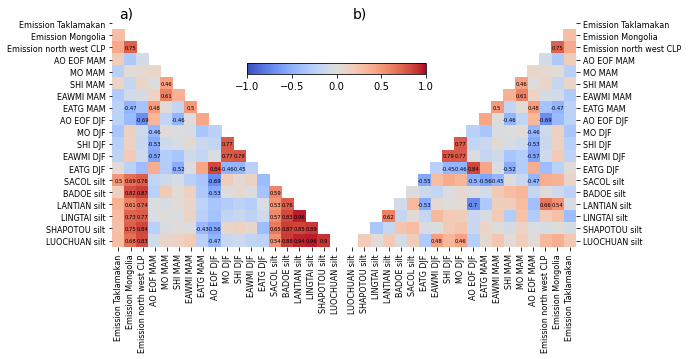

In [8]:
detrended_drydep_silt = detrended_drydep.drop([loc + ' clay' for loc in locs], axis=1)
detrended_wetdep_silt = detrended_wetdep.drop([loc + ' clay' for loc in locs], axis=1)
corrs_drydep = detrended_drydep_silt.corr()
p_values_drydep = detrended_drydep_silt.corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(len(detrended_drydep_silt.columns)) 
mask_drydep = np.triu(np.ones_like(corrs_drydep.values, dtype=bool))
corrs_triu_drydep = corrs_drydep.where((mask_drydep==False)) 
significant_corrs_drydep = corrs_triu_drydep.round(2).where((p_values_drydep <=0.05), other='')

corrs_wetdep = detrended_wetdep_silt.corr()
p_values_wetdep = detrended_wetdep_silt.corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(len(detrended_wetdep_silt.columns)) 
mask_wetdep = np.triu(np.ones_like(corrs_wetdep.values, dtype=bool))
corrs_triu_wetdep = corrs_wetdep.where((mask_wetdep==False)) 
significant_corrs_wetdep = corrs_triu_wetdep.round(2).where((p_values_wetdep <=0.05), other='')


fig ,ax = plt.subplots(ncols=2, figsize=(8.3, 11.7*0.7))
ax[0].set_aspect('equal')


sns.heatmap(corrs_drydep.values, mask=mask_drydep,
            xticklabels=corrs_drydep.columns.values,annot=significant_corrs_drydep,
            yticklabels=corrs_drydep.columns.values, ax=ax[0], cmap='coolwarm',fmt='',annot_kws={'fontsize':5.3, 'color':'black'}, 
            vmin=-1, vmax=1,cbar=False)

g=sns.heatmap(corrs_wetdep.values, mask=mask_wetdep,
            xticklabels=corrs_wetdep.columns.values,annot=significant_corrs_wetdep,
            yticklabels=corrs_wetdep.columns.values, ax=ax[1], cmap='coolwarm',fmt='',annot_kws={'fontsize':5.3, 'color':'black'}, 
            vmin=-1, vmax=1,cbar=False)
ax[1].set_aspect('equal')
cax=fig.add_axes([0.35,0.60,0.3,0.02])
fig.colorbar(cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=-1, vmax=1),cmap='coolwarm'),cax=cax, orientation='horizontal')
g.axes.invert_xaxis()
ax[1].yaxis.tick_right()
ax[1].set_yticklabels(ax[1].get_yticklabels(), rotation = 360, fontsize=8)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=8)
ax[0].set_yticklabels(ax[0].get_yticklabels(),  fontsize=8)
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=8)

plt.subplots_adjust(wspace=0.02)
add_letter(ax,y=1, fontsize=14)
if to_file:
    plt.savefig(snakemake.output.outpath_silt,bbox_inches='tight')